In [2]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from PIL import Image
from os.path import splitext

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
path="../input/cityscapes-image-pairs"
def images_upload(path):
    images=[]
    for root, subfolders, files in os.walk(path):
        for file in tqdm(files):
            filename=root+os.sep+file
            if filename.endswith('jpg') or filename.endwith('png'):

                images.append(filename)

    return images

images=images_upload(path)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 2975/2975 [00:00<00:00, 666455.93it/s]


In [4]:
def convert_image_rgb(data):
    imgs=[]
    for i in tqdm(data):
        img = cv2.imread(i,cv2.COLOR_BGR2RGB)
        del i
        imgs.append(img)
    return imgs
img = convert_image_rgb(images)

100%|██████████| 6950/6950 [01:45<00:00, 65.63it/s]


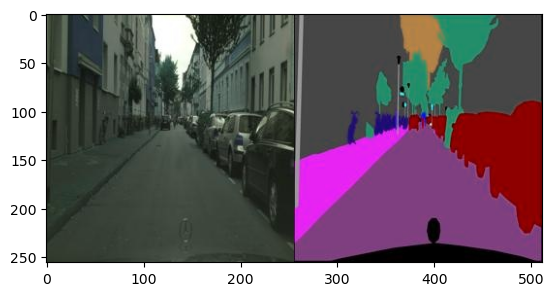

In [5]:
plt.imshow(img[np.random.randint(0,len(img))])

In [6]:
def split_input_mask(data):
    inputs=[]
    mask=[]
    for i in data:
        a=i[:,:256]
        inputs.append(a)
        b=i[:,256:]
        mask.append(b)
    return inputs,mask
inputs,mask=split_input_mask(img)

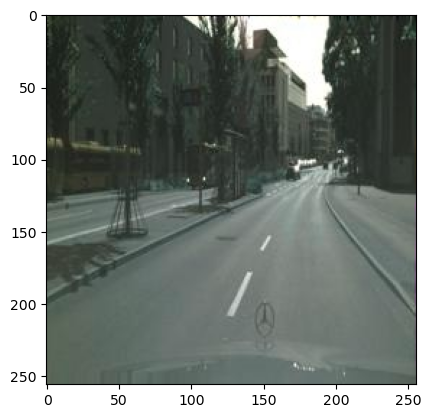

In [7]:
plt.imshow(inputs[0])

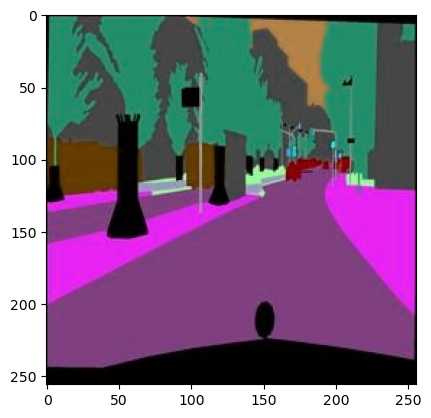

In [8]:
plt.imshow(mask[0])

In [9]:
def new_labels(mask):
    num_items = 1000 
    color_array = np.random.choice(range(256), 3*num_items).reshape(-1,3)
    num_classes = 10
    label_model = KMeans (n_clusters = num_classes)
    label_model.fit(color_array)
    labels=[]
    for i in tqdm(range(len(mask))):
        label_class= label_model.predict(mask[i].reshape(-1,3)).reshape(256,256) 
        labels.append(label_class)

    return labels
labels=new_labels (mask)
idx=np.random.randint(0,len(labels))
classes, freq=np.unique(labels[idx], return_counts=True)
print(f' number of classes:{len(classes)}')

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 6950/6950 [00:23<00:00, 301.77it/s]

 number of classes:10


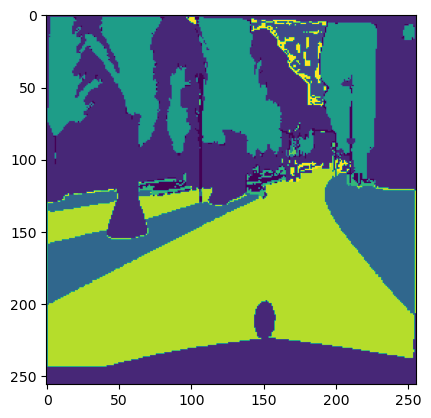

In [10]:
plt.imshow(labels[0])

In [11]:
def rescaled(data):
    rescaled=[]
    for i in tqdm(data):
        img = tf.image.convert_image_dtype(i, tf.float32)
        del i
        rescaled.append(img)
    return rescaled
rescaled_input = rescaled(inputs)

100%|██████████| 6950/6950 [00:10<00:00, 679.09it/s] 


In [12]:
 def build_model(inputsize=(256,256,3),classes=None):
    inputs = tf.keras.Input(shape=(inputsize))

    conv = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv1')(inputs)
    x = tfl.BatchNormalization()(conv)
    x = tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv2')(x)
    x = tfl.BatchNormalization()(x1)
    x = tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv3')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)
    x2 = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv4')(x)
    x = tfl.BatchNormalization()(x2)
    x = tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv5')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)
    x3 = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv6')(x)
    x= tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv7')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv8')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x3], axis=3)
    
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv9')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)
    x = tfl.Conv2D(128, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv10')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x2], axis=3)

    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv11')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)
    x = tfl.Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv12')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x1], axis=3)

    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv25')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)
    x = tfl.Conv2D(32, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv26')(x)
    x = tfl.BatchNormalization()(x)
    x = tfl.LeakyReLU()(x)
    
    outputs = tfl.Conv2D(classes, (1, 1), padding="same", activation='softmax', name='Outputs')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    final_model.summary()
    return final_model

In [13]:
mymodel=build_model(classes=10)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['Conv1[0][0]']                  
 alization)                     )                                                             

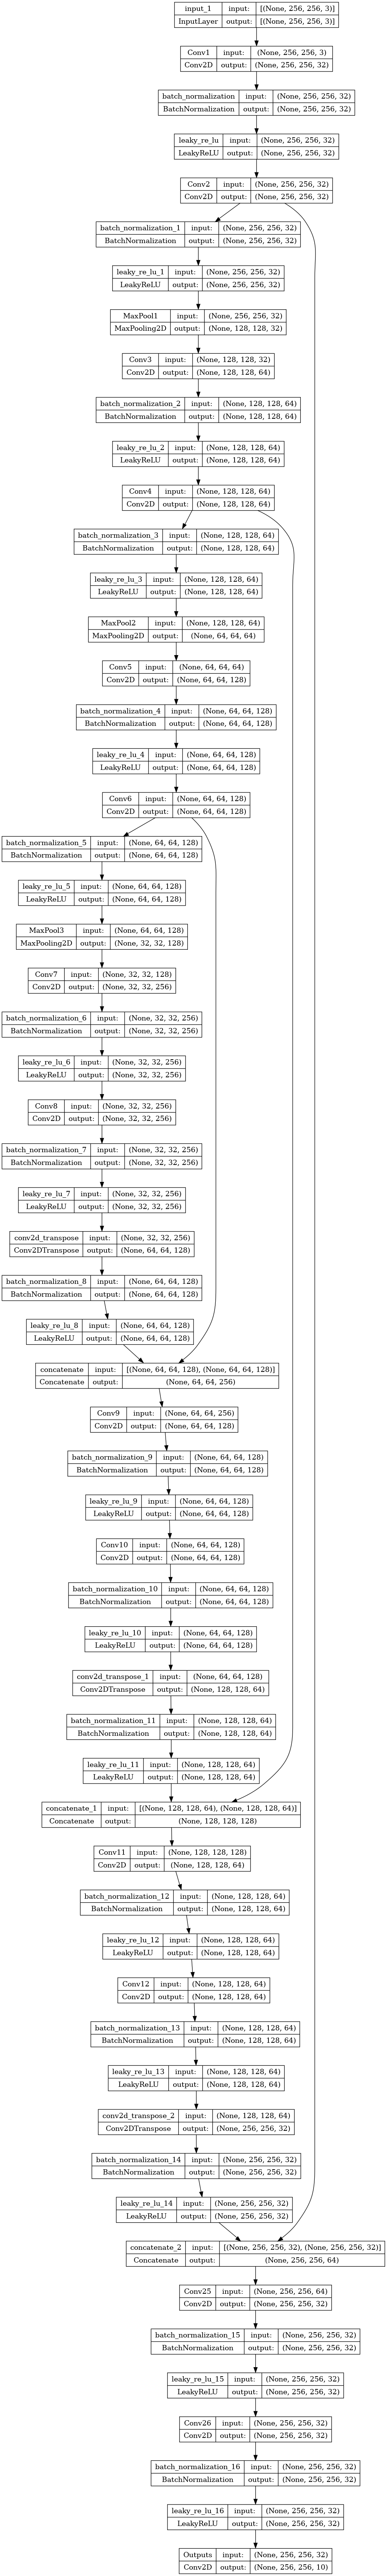

In [14]:
img_file = './model_arch.png'

tf.keras.utils.plot_model(mymodel, to_file=img_file, show_shapes=True, show_layer_names=True)

In [15]:
def split_data(x,y,test_size=0.2):
    x1=np.array(x)
    print(x1.shape)
    del x
    y1=np.array(y)
    print(y1.shape)
    del y
    x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=test_size)
    return  x_train, x_test, y_train, y_test

In [16]:
x_train, x_test, y_train, y_test=split_data(rescaled_input[:1300],labels[:1300],test_size=0.2)

(1300, 256, 256, 3)
(1300, 256, 256)


In [17]:
x_train.shape

(1040, 256, 256, 3)

In [18]:
y_train.shape

(1040, 256, 256)

In [19]:
mymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=['acc'])
hist=mymodel.fit(x_train,y_train,batch_size=16,epochs=5)

Epoch 1/5
65/65 [==============================] - 56s 326ms/step - loss: 1.1613 - acc: 0.6298
Epoch 2/5
65/65 [==============================] - 22s 332ms/step - loss: 0.8997 - acc: 0.7071
Epoch 3/5
65/65 [==============================] - 22s 339ms/step - loss: 0.8396 - acc: 0.7208
Epoch 4/5
65/65 [==============================] - 22s 345ms/step - loss: 0.7831 - acc: 0.7364
Epoch 5/5
65/65 [==============================] - 22s 346ms/step - loss: 0.7493 - acc: 0.7481


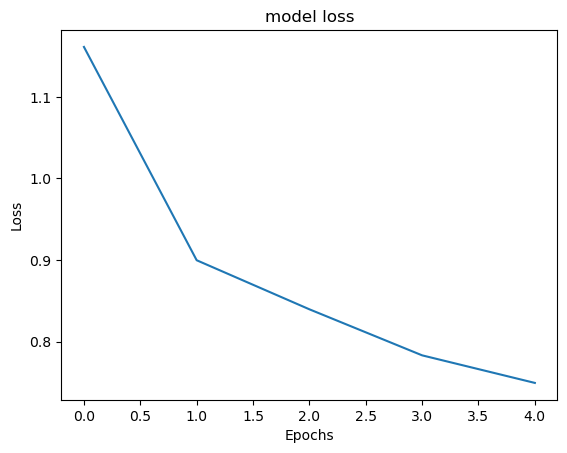

In [20]:
plt.plot(hist.history['loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.show()

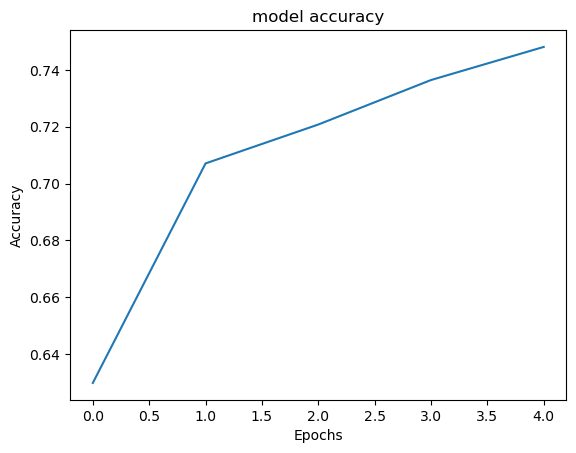

In [21]:
plt.plot(hist.history["acc"])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [22]:
pred=mymodel.predict(x_test)
y_pred=tf.argmax(pred,axis=-1)

9/9 [==============================] - 11s 438ms/step


In [23]:
def show_predications(x_test,y_test,y_pred):
    idx=np.random.randint(0,len(y_pred))
    fig, axes = plt.subplots(1,3,figsize=(10,10))
    axes[0].imshow(x_test[idx])
    axes[0].set_title("original")
    axes[1].imshow(y_test[idx])
    axes[1].set_title("mask")
    axes[2].imshow(y_pred[idx])
    axes[2].set_title("predicated")

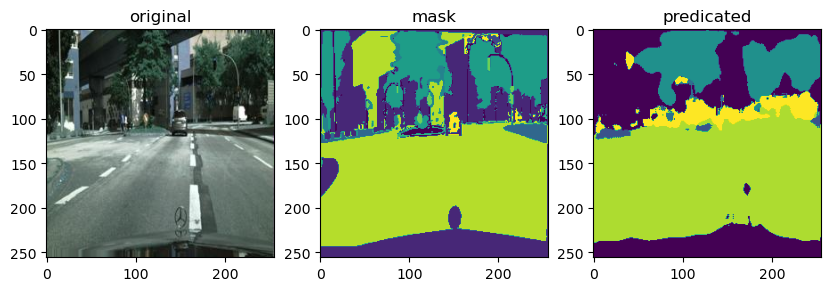

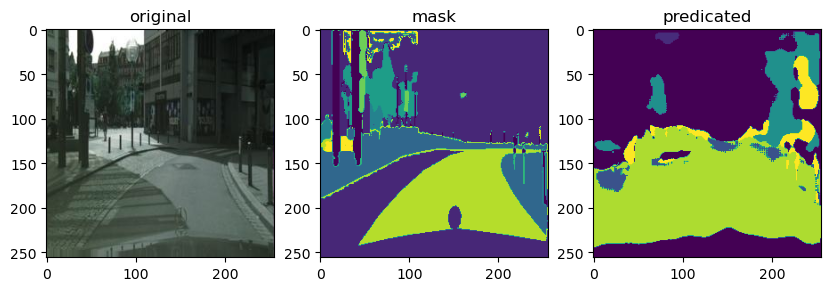

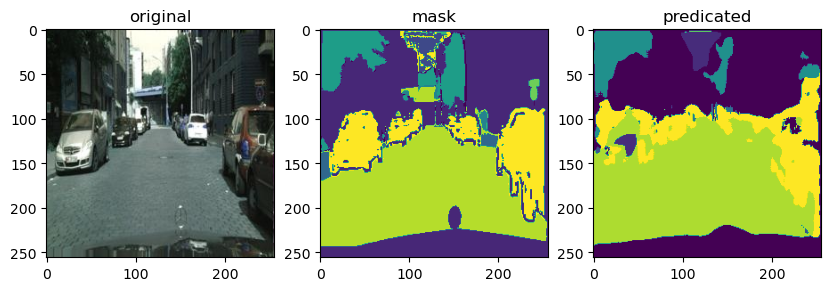

In [24]:
for i in range(3):
    show_predications(x_test,y_test,y_pred)